In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ccnlab/Development/dl4rl/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sequence_generator import create_stim_sequence
from rl_models import PRL
from utils.simulate_utils import generate_valid_mappings
from concurrent.futures import ProcessPoolExecutor
from sim_agent import simulate_agent
import random
from utils.simulate_utils import generate_beta_with_diff_means_sim_vars


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pval = 1
num_blocks = 12

num_stimuli_list = [6, 6]
min_switches = [1200, 1200]
iter_per_stimuli = 13
num_actions = 3

all_seq = []
for i in range(num_blocks):
    all_seq.append(create_stim_sequence(iter_per_stimuli, num_stimuli_list[0]))

In [ ]:
N_AGENTS = 3000
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, a1, b1, _, _ = generate_beta_with_diff_means_sim_vars(
    mean1, mean1, var, N_AGENTS, 0, 0.4
)
print(a1, b1)

In [ ]:
# Prepare the sequences

N_AGENTS = 500
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
    mean1, mean1, var, N_AGENTS, 0, 0.4
)
# simulate N_AGENTS agents with randomly sampled alphas and betas
bias_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
    0.5, 0.5, 0.05, N_AGENTS, 0, 1
)

sticky_dist = np.random.uniform(-0.2, 0.2, N_AGENTS)
beta_dist = np.random.uniform(0.2, 0.8, N_AGENTS)
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = [
        executor.submit(
            simulate_agent,
            a,
            pval,
            num_blocks,
            num_stimuli_list,
            min_switches,
            iter_per_stimuli,
            num_actions,
            all_seq,
            params_dist={
                "alpha": 1,
                "phi": phi_dist[a],
                "stickiness": sticky_dist[a],
                "bias": bias_dist[a],
                "beta": beta_dist[a],
            },
        )
        for a in range(N_AGENTS)
    ]
    train_data_list = [future.result() for future in tqdm.tqdm(futures)]

train_df = pd.concat(train_data_list)
train_df.head(3)

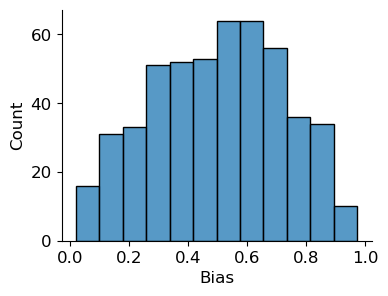

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

bias_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
    0.5, 0.5, 0.05, 500, 0, 1
)

fig = plt.figure(figsize=(4, 3))
ax = sns.histplot(bias_dist)
ax.set_xlabel('Bias')
ax.set_ylabel('Count')
sns.despine()

In [ ]:
# train_df = train_df.drop('delay_since_last_correct_cat', axis=1)
# train_df.columns

In [ ]:
max_num_trials = train_df.trials.max() + 1
filename = f"../data/wm_6s3a/{N_AGENTS}a_{num_blocks}b_{max_num_trials}t_4wm_no_switch_st22v1.csv"
print(filename)
train_df.to_csv(filename)

In [ ]:
# from sim_agent import get_last_stimuli_trial

# filename = "../data/rlf_6s3a/3000a_12b_78t_3ParamRL_no_switch_st22.csv"
# train_df = pd.read_csv(filename)

# all_delay_since_last_stimuli = []
# for id, df in train_df.groupby(['agentid', 'block_no']):
#     delay_since_last_stimuli = df.trials - get_last_stimuli_trial(df)
#     all_delay_since_last_stimuli.extend(delay_since_last_stimuli.tolist())

# train_df['delay_since_last_stimuli'] = all_delay_since_last_stimuli
# train_df['delay_since_last_stimuli'] = train_df['delay_since_last_stimuli'].fillna(0).astype(int)
# train_df[train_df.stimuli == 0][['stimuli', 'trials', 'rewards', 'delay_since_last_stimuli', 'delay_since_last_correct']].head(12)

In [3]:
train_df = pd.read_csv('../data/wm_6s3a/500a_12b_78t_4wm_no_switch_st22.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df["delay_since_last_correct_cat"] = train_df["delay_since_last_correct"].apply(
    lambda x: "2+" if x > 2 else str(x)
)
# train_df[['stimuli', 'trials', 'rewards', 'delay_since_last_correct']].tail(10)
res = train_df[train_df.delay_since_last_correct > 0]
res = (
    res.groupby(["agentid", "delay_since_last_correct_cat", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_correct_cat",
    y="rewards",
    order=["1", "2", "2+"],
    hue="condition",
    ax=ax,
    ci=95,
)
ax.set_xlabel("delay_since_last_correct")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()

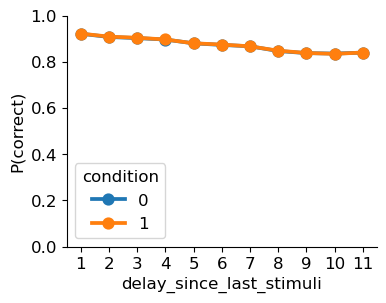

In [ ]:


res = train_df[train_df.delay_since_last_stimuli > 0]
res = (
    res.groupby(["agentid", "delay_since_last_stimuli", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_stimuli",
    y="rewards",
    hue="condition",
    ax=ax,
)
ax.set_xlabel("delay_since_last_stimuli")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()

In [4]:
from utils.feature_utils import get_iter_acc_without_switches

iter_acc = get_iter_acc_without_switches(train_df)
iter_acc.head(2)

,stim_iter,stimuli,rewards,condition,actions,trials,agentid,block_no
0,1,0,1,1,0,0,0,0
1,1,1,0,1,1,1,0,0


(468000, 2)


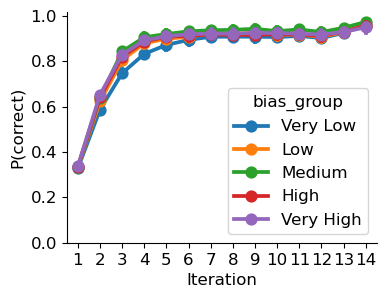

In [14]:
print(train_df[['agentid', 'bias']].shape)
iter_acc['bias'] = train_df['bias']

# Create 5 equal-width bins for bias values
iter_acc['bias_group'] = pd.qcut(iter_acc['bias'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Group by bias group and calculate mean rewards
bias_group_stats = iter_acc.groupby(["agentid",  'stim_iter', 'bias_group'])['rewards'].mean().reset_index()

# Plot the results
plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.pointplot(
    data=bias_group_stats,
    x="stim_iter",
    y="rewards",
    hue="bias_group",
    ax=ax,
)
ax.set_xlabel("Iteration")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))
sns.despine()


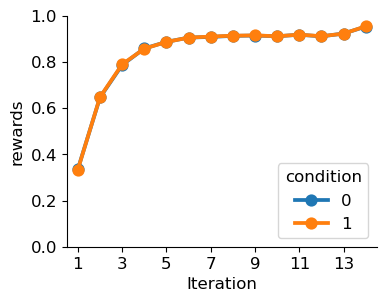

In [16]:
res = (
    iter_acc.groupby(["agentid", "stim_iter", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="stim_iter",
    y="rewards",
    hue="condition",
    ax=ax,
)
ax.set_xlabel("Iteration")
# ax.hlines(0.33, xmin=0, xmax=18, color='red')
max_num_iter = res.stim_iter.max()
ax.set_xticks(np.round(np.arange(0, max_num_iter, 2), 2))
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

# fig.tight_layout(rect=[0, 0, 1, 0.95])

sns.despine()